<a href="https://colab.research.google.com/github/abdallaho98/AutoSpeech/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip3 install ktrain

     |████████████████████████████████| 25.2MB 1.5MB/s 
     |████████████████████████████████| 983kB 6.7MB/s 
     |████████████████████████████████| 245kB 20.8MB/s 
     |████████████████████████████████| 552kB 25.6MB/s 
     |████████████████████████████████| 3.7MB 31.2MB/s 
     |████████████████████████████████| 870kB 33.8MB/s 
     |████████████████████████████████| 1.0MB 45.1MB/s 
  Created wheel for ktrain: filename=ktrain-0.12.3-cp36-none-any.whl size=25228500 sha256=ddf465da12af2c2c4c4d74e6d939d91ba6d1c372be049da1da88ec8b7fa531cd
  Stored in directory: /root/.cache/pip/wheels/93/8f/77/a036a53942ede8e46e333d39b6abd9aaf3ab91aaf96d83e70f
  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=3c7d40d2c0d1a46af30bf9587a1c19227303ffa3c2717a3a06b44c02af2ba7e4
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [0]:
import ktrain
from ktrain import text

In [12]:
import pandas as pd
filepath = 'legalts.txt'
df = pd.DataFrame(columns=('rating', 'review'))
with open(filepath) as fp:
   line = fp.readline()
   cnt = 0
   while line:
       x = line.strip().split("  ")
       df.loc[cnt] = [int(x[1]) , x[0]]
       line = fp.readline()
       cnt += 1
df['rating'] = df['rating'].apply(lambda x: 'neg' if x < 3 else 'pos')
df.columns = ['label', 'text']
df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)
df = df[['text', 'neg', 'pos']]
df.head()

,text,neg,pos
0,يمكن أن ينصب الفحص الطبي على السوابق الوراثية ...,0,1
1,يمكن للمكتب، بقطع النظر عن أحكام المادة 4 أعلا...,0,1
2,(يمكن اكتساب الجنسية الجزائرية بالزواج من جزائ...,0,1
3,يمكن إنشاء فروع في دائرة اختصاص المحاكم على مس...,0,1
4,يمكن أحد الطرفين أن يفسخ العقد في أي وقت شريطة...,0,1


In [20]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 
                                                                   'text', # name of column containing review text
                                                                   label_columns=['neg', 'pos'],
                                                                   maxlen=575, 
                                                                   max_features=100000,
                                                                   preprocess_mode='standard',
                                                                   val_pct=0.1,
                                                                   ngram_range=3)

language: ar
Word Counts: 1013
Nrows: 46
46 train sequences
train sequence lengths:
	mean : 45
	95percentile : 87
	99percentile : 133
Adding 3-gram features
max_features changed to 103555 with addition of ngrams
Average train sequence length with ngrams: 130
train (w/ngrams) sequence lengths:
	mean : 131
	95percentile : 258
	99percentile : 395
x_train shape: (46,575)
y_train shape: (46, 2)
6 test sequences
test sequence lengths:
	mean : 20
	95percentile : 32
	99percentile : 32
Average test sequence length with ngrams: 32
test (w/ngrams) sequence lengths:
	mean : 33
	95percentile : 64
	99percentile : 68
x_test shape: (6,575)
y_test shape: (6, 2)


In [21]:
model = text.text_classifier('nbsvm', (x_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=32)

Is Multi-Label? False
compiling word ID features...
maxlen is 575
building document-term matrix... this may take a few moments...
rows: 1-46
computing log-count ratios...
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:453: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


2/2 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.5652
Epoch 2/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.5652
Epoch 3/5
2/2 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5870
Epoch 4/5
2/2 [==============================] - 0s 3ms/step - loss: 0.5161 - accuracy: 0.9130
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: 0.0203 - accuracy: 1.0000


done.


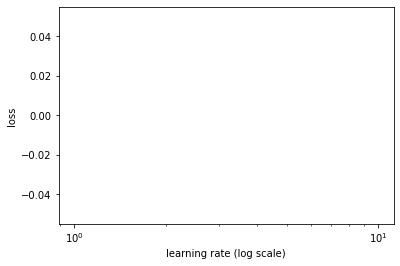

In [22]:
learner.lr_find(show_plot=True)

In [23]:
learner.autofit(5e-3, 1)



begin training using triangular learning rate policy with max lr of 0.005...
2/2 [==============================] - 0s 100ms/step - loss: 0.6787 - accuracy: 0.5870 - val_loss: 0.7085 - val_accuracy: 0.6667


In [24]:
learner.view_top_losses(n=1, preproc=preproc)

AttributeError: ignored

In [0]:
p = ktrain.get_predictor(learner.model, preproc)

In [26]:
p.predict("لا يجوز أن يكون تأويل العبارات الغامضة في عقود الاذعان ضارا بمصلحة الطرف المذعن")

'neg'

In [27]:
p.predict("يسقط الحق في إبطال العقد إذا لم يتمسك به صاحبه خلال خمس )5( سنوات.")

'neg'

In [30]:
p.predict("يجوز أن يؤمر بالنفاذ المعجل بالنسبة لهذا الإجرا")

'pos'

In [34]:
p.predict("يجوز تخفيض العقوبة المنصوص عليها قانونا بالنسبة للشخص الطبيعي الذي قضي بإدانته وتقررت إفادته بظروف مخففة")

'pos'